In [20]:
# libraries
import pandas as pd
import numpy as np
# plot libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sns.set_palette('husl',8)
%matplotlib inline

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from collections import Counter

import statsmodels.api as sm
from datetime import datetime
from regressors import stats
from scipy.stats import norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder,RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score,roc_auc_score,confusion_matrix,roc_curve,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,cross_validate,RandomizedSearchCV,train_test_split
import lightgbm as lgbm

warnings.filterwarnings('ignore')

## Explore data analysis

In [103]:
credit=pd.read_csv('/Users/apple/Documents/Intern/creditcard.csv')

myDF = credit.copy()

In [104]:
print(myDF.shape)

print(myDF.columns)

print(myDF.head())

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.16717

0    284315
1       492
Name: Class, dtype: int64


Text(0.5, 1.0, 'Class Distributions:\n 0 = No Fraud and 1 = Fraud')

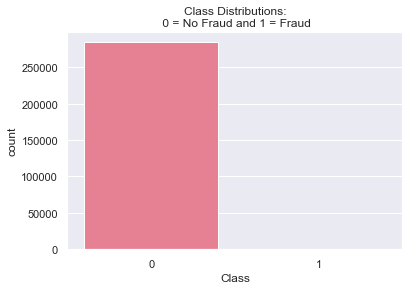

In [105]:
# check class distribution to see imbalanced dataset
print(myDF["Class"].value_counts())
sns.countplot('Class', data = myDF)
plt.title('Class Distributions:\n 0 = No Fraud and 1 = Fraud')

Text(0.5, 1.0, 'Distribution of Amount')

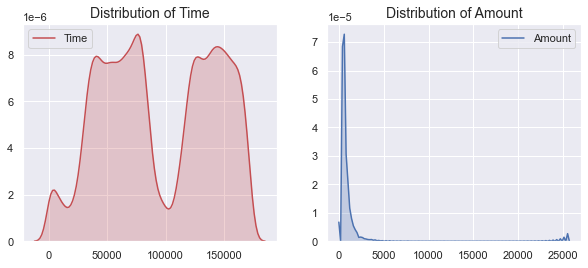

In [106]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(myDF.Time,shade=True,ax=ax[0],color='r')
ax[0].set_title('Distribution of Time',fontsize=14)
sns.kdeplot(myDF.Amount,shade=True,ax=ax[1],color='b')
ax[1].set_title('Distribution of Amount',fontsize=14)
#data have not scaled yet

Text(0.5, 1.0, 'Distribution of scaled Amount')

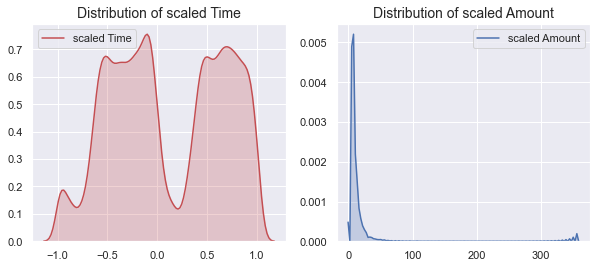

In [112]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(myDF['scaled Time'],shade=True,ax=ax[0],color='r')
ax[0].set_title('Distribution of scaled Time',fontsize=14)
sns.kdeplot(myDF['scaled Amount'],shade=True,ax=ax[1],color='b')
ax[1].set_title('Distribution of scaled Amount',fontsize=14)

In [107]:
# Change time to minutes and hours to better understand data
timedelta = pd.to_timedelta(myDF['Time'], unit='s')
myDF['Time_min'] = (timedelta.dt.components.minutes).astype(int)
myDF['Time_hrs'] = (timedelta.dt.components.hours).astype(int)

#scale Time and Amount using robustscaler which not influenced 
#by a few number of very large marginal outliers
scaler = RobustScaler()
myDF['scaled Time']=scaler.fit_transform(myDF['Time'].values.reshape(-1,1))
myDF['scaled Amount']=scaler.fit_transform(myDF.Amount.values.reshape(-1,1))

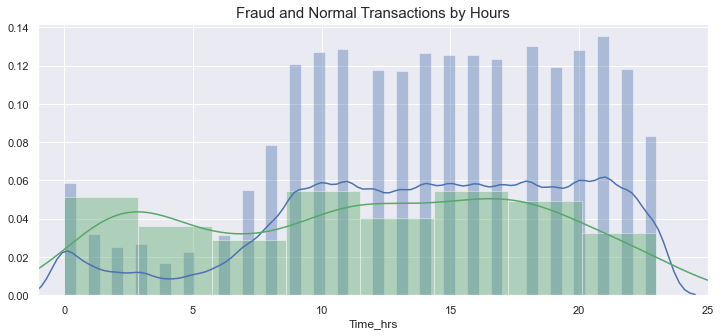

In [113]:
# hours
plt.figure(figsize=(12,5))
sns.distplot(myDF[myDF['Class'] == 0]["Time_hrs"], 
             color='b')
sns.distplot(myDF[myDF['Class'] == 1]["Time_hrs"], 
             color='g')
plt.title('Fraud and Normal Transactions by Hours', fontsize=15)
plt.xlim([-1,25])
plt.show()

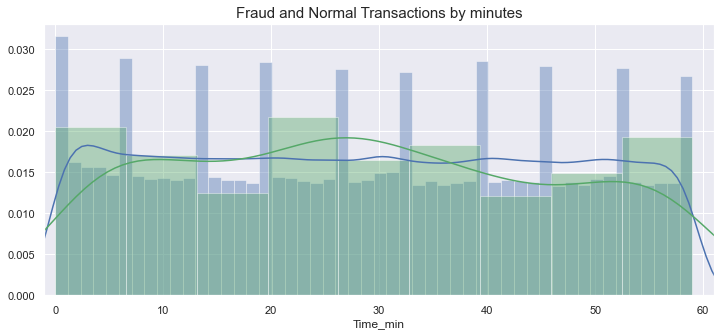

In [109]:
# minutes
plt.figure(figsize=(12,5))
sns.distplot(myDF[myDF['Class'] == 0]["Time_min"], 
             color='b')
sns.distplot(myDF[myDF['Class'] == 1]["Time_min"], 
             color='g')
plt.title('Fraud and Normal Transactions by minutes', fontsize=15)
plt.xlim([-1,61])
plt.show()

In [110]:
fraud = myDF[myDF['Class'] == 1]
no_fraud = myDF[myDF['Class'] == 0]

print("Fraud transaction statistics")
print(fraud["Amount"].describe())
print("\nNormal transaction statistics")
print(no_fraud["Amount"].describe())

Fraud transaction statistics
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal transaction statistics
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


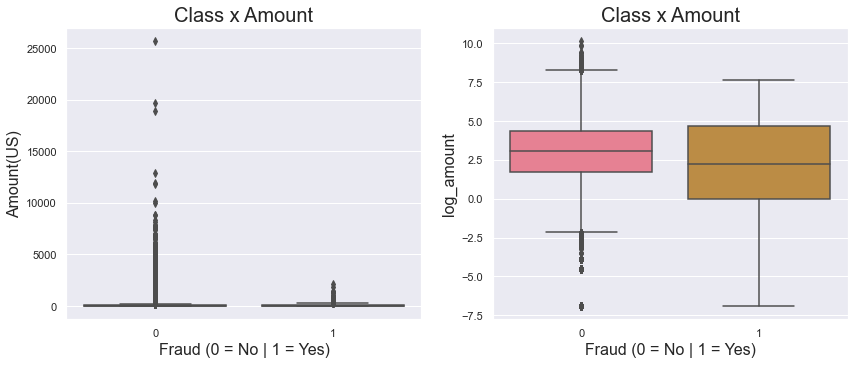

In [115]:
# Distribution of Amount Transactions by Class (Fraud or No Fraud)
myDF['log_amount'] = np.log(myDF.Amount + 0.001)

plt.figure(figsize=(14,6))

plt.subplot(121)
ax = sns.boxplot(x = "Class", y = "Amount", data = myDF)
ax.set_title("Class x Amount", fontsize=20)
ax.set_xlabel("Fraud (0 = No | 1 = Yes)", fontsize=16)
ax.set_ylabel("Amount(US)", fontsize = 16)

plt.subplot(122)
ax1 = sns.boxplot(x ="Class", y = "log_amount", data = myDF)
ax1.set_title("Class x Amount", fontsize=20)
ax1.set_xlabel("Fraud (0 = No | 1 = Yes)", fontsize=16)
ax1.set_ylabel("log_amount", fontsize = 16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

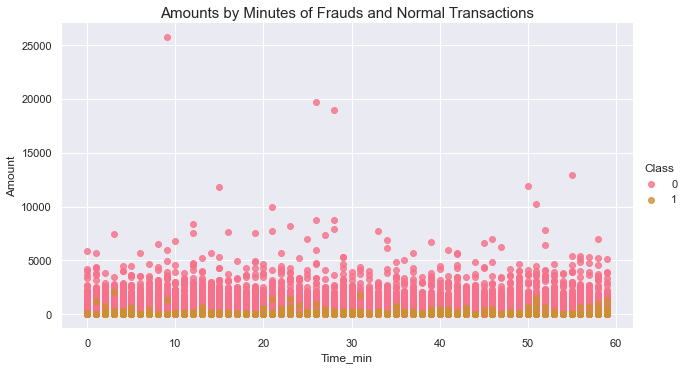

In [116]:
# Looking a Scatter Plot of the Amount and time_min distribuition of Fraud transactions
ax = sns.lmplot(y="Amount", x="Time_min", fit_reg = False, aspect = 1.8, data=myDF, hue='Class')
plt.title("Amounts by Minutes of Frauds and Normal Transactions",fontsize=15)
plt.show()

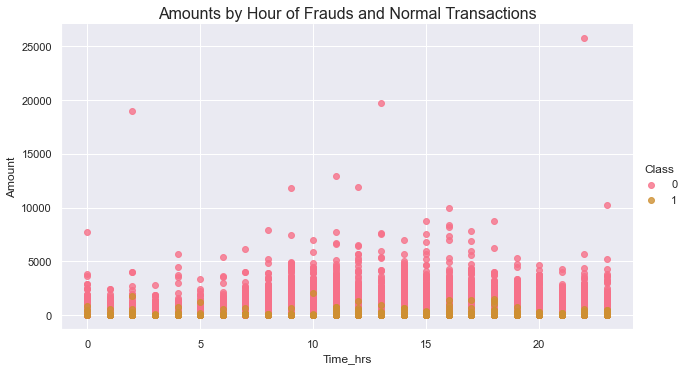

In [117]:
# Looking a Scatter Plot of the Amount and time_hrs distribuition of Fraud transactions
ax = sns.lmplot(y = "Amount", x = "Time_hrs", fit_reg = False, aspect = 1.8, data = myDF, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)

plt.show()

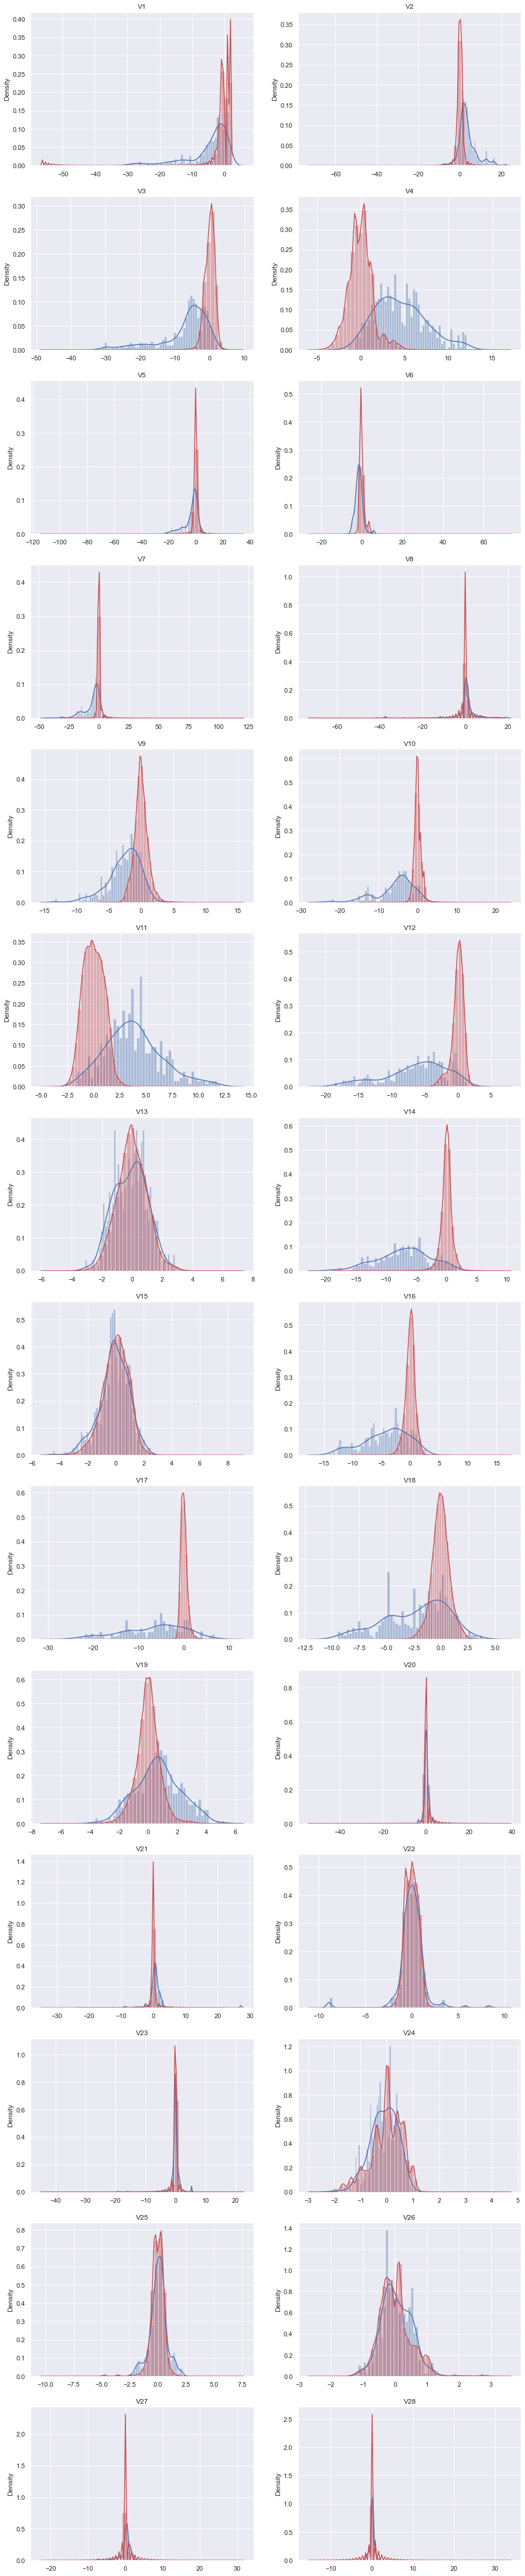

In [118]:
# Distributions of each V Column
columns = myDF.iloc[:,1:29].columns

fraud_trans = (myDF.Class == 1)
regular_trans = (myDF.Class == 0)

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(myDF[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(myDF[col][fraud_trans], bins = 50, color='b') 
    sns.distplot(myDF[col][regular_trans], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

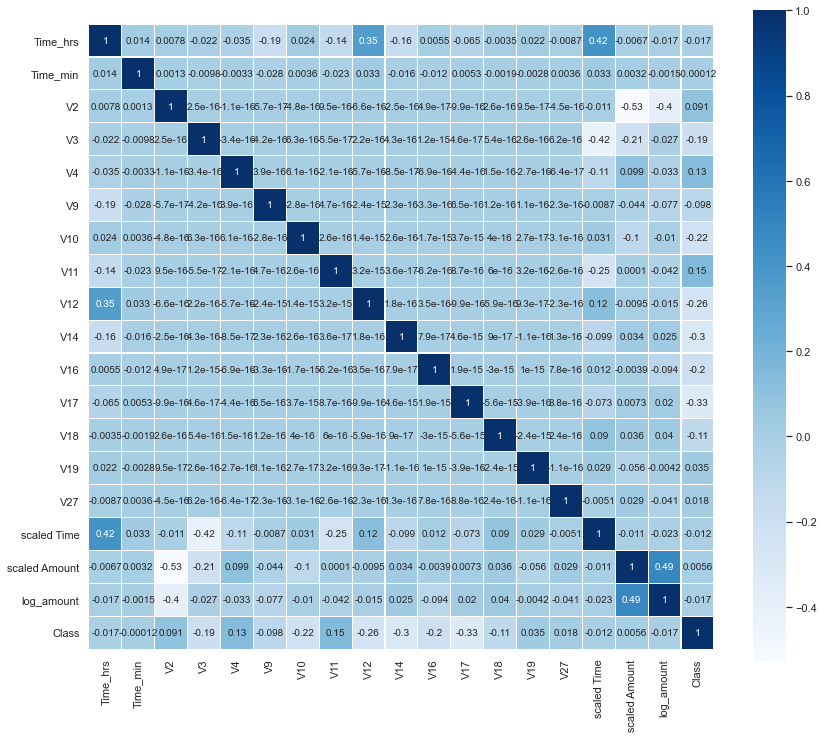

In [122]:
#A heatmap is a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors.

plt.figure(figsize=(14,12))

sns.heatmap(myDF[["Time_hrs","Time_min","V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27",'scaled Time', 'scaled Amount',
       'log_amount',"Class"]].corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.Blues, linecolor='white', annot=True)

plt.show()

## Modeling 

In [5]:
# Load data
data = credit.copy()
x = data.iloc[:,0:30].values
y = data['Class'].values
# check whether the number of rows are the same
assert x.shape[0] == y.shape[0]

In [7]:
# count the number of times each time point occurs
time = data.iloc[:,0]
time = time.tolist()
c = collections.Counter(time)
lst = list(c.items())
# separate key and values
key = []
values = []
for i in range(len(lst)):
    key.append(lst[i][0])
    values.append(lst[i][1])

In [8]:
# Time column transformation
for i in range(len(x)):
    x[i][0] = values[key.index(x[i][0])]

In [9]:
#data
#x
# Transfer x and y to ndarray to do the resampling
x = x.tolist()
X = np.asarray(x).reshape(284807,30)
y = np.asarray(y).reshape(284807,1)

SMOTE Resampling

In [10]:
# SMOTE resampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
# scale data
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_res)

In [11]:
ols = linear_model.LinearRegression()
ols.fit(X_scaled, y_res)

# To calculate the p-values of beta coefficients: 
print("coef_pval:\n", stats.coef_pval(ols, X_scaled, y_res))

# to print summary table:
print("\n=========== SUMMARY ===========")
stats.summary(ols, X_scaled, y_res)

coef_pval:
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.02281383e-01 0.00000000e+00 1.21584220e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.94049246e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.62680316e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]

=========== SUMMARY ===========
Residuals:
    Min      1Q  Median      3Q     Max
-0.5475  0.1703  0.3552  0.8162  5.0285


Coefficients:
            Estimate  Std. Error    t value   p value
_intercept  0.500000    0.000387  1291.4104  0.000000
x1         -0.026515    0.000407   -65.1506  0.000000
x2         -0.093070    0.001092   -85.2277  0.000000
x3          0.029694    0.001315    22.5770  0.000000
x4          0.000818    0.001570     0.5211  0.602281
x5          0.173494    0.000878   197.5196  0.000

In [13]:
import statsmodels.api as sm
X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_res, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                 3.664e+04
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        02:44:22   Log-Likelihood:            -1.0679e+05
No. Observations:              568630   AIC:                         2.136e+05
Df Residuals:                  568599   BIC:                         2.140e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000      0.000   1291.375      0.0

In [26]:
# Variable Selection
df = pd.DataFrame(data=X_scaled)
data1 = df.loc[:,[0,2,8,10,11,13,15,17,19,20,21,23,24,25,26,27,28,29]]
#data1
x_new = data1.values
# Transfer x and y to ndarray
x_new = x_new.tolist()
X_new = np.asarray(x_new).reshape(568630,18)
y_new = y_res.reshape(568630,1)

In [16]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.5, random_state=0)

In [10]:
# 0/1 loss function build
def error_rate(y_true,y_predict):
    correct = 0
    for i in range(len(y_true)):
        if y_predict[i] == y_true.ravel()[i]:
            correct = correct + 1
    return (1 - correct/len(y_true))

In [12]:
def rbf_error(C_values):
    rbf_error = []
    # Build model 
    clf_rbf = SVC(C = C_values, kernel = 'rbf', gamma = 'auto')
    clf_rbf.fit(X_train,y_train)
    # Predict y for test data
    y_rbf_predict = clf_rbf.predict(X_test)
    # Error calculation
    error_rbf = error_rate(y_test,y_rbf_predict)
    return error_rbf

In [13]:
C_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lst_err = []
for i in C_list:
    lst_err.append(rbf_error(i)) 

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\

In [18]:
C_grid = np.logspace(-4,2,7)

Text(0.5, 1.0, 'RBF Kernel with different C values')

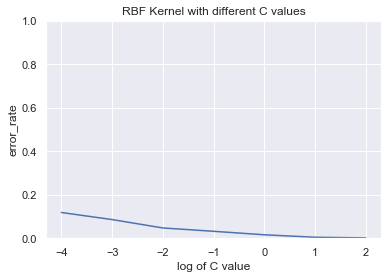

In [21]:
plt.xlabel('log of C value');
plt.ylabel('error_rate');

plt.ylim([0.0, 1]);
plt.plot(np.log10(C_grid),lst_err)
plt.title('RBF Kernel with different C values')

In [34]:
clf_rbf = SVC(C = 1, kernel = 'rbf', gamma = 'auto', probability=True)

In [35]:
clf_rbf.fit(X_train,y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=1, gamma='auto', probability=True)

In [24]:
y_pred_rbf_1 = clf_rbf.predict(X_test)

In [25]:
confusion_matrix(y_test, y_pred_rbf_1)

array([[140845,   1340],
       [  3265, 138865]], dtype=int64)

In [39]:
proba = clf_rbf.predict_proba(X_ori)[:,1]

In [42]:
roc_auc_score(y,proba)

0.5212419409423504

In [27]:
df = pd.DataFrame(data=X)
data_ori_1 = df.ix[:,[0,2,8,10,11,13,15,17,19,20,21,23,24,25,26,27,28,29]]

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [29]:
x_ori = data_ori_1.values
# Transfer x and y to ndarray
x_ori = x_ori.tolist()
X_ori = np.asarray(x_ori).reshape(284807,18)

In [31]:
y_ori_pred_rbf = clf_rbf.predict(X_ori)
confusion_matrix(y_res, y_ori_pred_rbf)

array([[249962,  34353],
       [   447,     45]], dtype=int64)

Neural Network

Using Function

In [17]:
# 0/1 loss function build
def error_rate(y_true,y_predict):
    correct = 0
    for i in range(len(y_true)):
        if y_predict[i] == y_true.ravel()[i]:
            correct = correct + 1
    return (1 - correct/len(y_true))

## Cross-validation function build
def make_folds(num_folds=1):
    x_folds = list()
    y_folds = list()
    bin_len = int(len(X)/num_folds)
    x_folds = list(X_new[a:a+bin_len,:] for a in range(0,len(X_new),bin_len))
    y_folds = list(y_new[a:a+bin_len,:] for a in range(0,len(y_new),bin_len))
    # TODO: Complete method to generate partition into folds.
    return x_folds,y_folds
x_folds, y_folds = make_folds(5)

## lbfgs - Define a function helps to see the average error for cross-validation process
def lbfgs_average_error(layers):
    error_relu = 0
    error_log = 0
    for test_index in [0,1,2,3,4]:
        # Get the train dataset
        xTrain = np.concatenate([x_folds[i] for i in [0,1,2,3,4] if i!=test_index],axis = 0)
        yTrain = np.concatenate([y_folds[i] for i in [0,1,2,3,4] if i!=test_index],axis = 0)
        # Get the test dataset
        xTest = x_folds[test_index]
        yTest = y_folds[test_index]
        # Build model
        mlp_lbfgs_relu = MLPClassifier(hidden_layer_sizes=[layers],activation='relu',solver = 'lbfgs',alpha=0.0001,max_iter=200, tol=1e-6)
        mlp_lbfgs_relu.fit(xTrain,yTrain)
        mlp_lbfgs_log = MLPClassifier(hidden_layer_sizes=[layers],activation='logistic',solver = 'lbfgs',alpha=0.0001,max_iter=200, tol=1e-6)
        mlp_lbfgs_log.fit(xTrain,yTrain)
        # Predict y
        y_relu_predict = mlp_lbfgs_relu.predict(xTest)
        y_log_predict = mlp_lbfgs_log.predict(xTest)
        # Error calculation
        error_relu = error_relu+error_rate(yTest,y_relu_predict)
        error_log = error_log+error_rate(yTest,y_log_predict)
    avg_relu_err = error_relu/5
    avg_log_err = error_log/5
    return avg_relu_err,avg_log_err

## adam - Define a function helps to see the average error for cross-validation process
def adam_average_error(layers):
    error_relu = 0
    error_log = 0
    for test_index in range(len(x_folds)):
        # Get the train dataset
        xTrain = np.concatenate([x_folds[i] for i in [0,1,2,3,4] if i!=test_index],axis = 0)
        yTrain = np.concatenate([y_folds[i] for i in [0,1,2,3,4] if i!=test_index],axis = 0)
        # Get the test dataset
        xTest = x_folds[test_index]
        yTest = y_folds[test_index]
        # Build model
        mlp_relu = MLPClassifier(hidden_layer_sizes=[layers],activation='relu',alpha=0.0001,max_iter=400, tol=1e-6)
        mlp_relu.fit(xTrain,yTrain)
        mlp_log = MLPClassifier(hidden_layer_sizes=[layers],activation='logistic',alpha=0.0001,max_iter=400, tol=1e-6)
        mlp_log.fit(xTrain,yTrain)
        # Predict y
        y_relu_predict = mlp_relu.predict(xTest)
        y_log_predict = mlp_log.predict(xTest)
        # Error calculation
        error_relu = error_relu+error_rate(yTest,y_relu_predict)
        error_log = error_log+error_rate(yTest,y_log_predict)
    avg_relu_err = error_relu/5
    avg_log_err = error_log/5
    return avg_relu_err,avg_log_err

K-fold validation

In [21]:
lyer_list = [1,2,3,4,5]
lst_err = []
for i in lyer_list:
    lst_err.append(lbfgs_average_error(i)) 

relu_err = []
log_err = []
for i in range(len(lst_err)):
    relu_err.append(lst_err[i][0])
    log_err.append(lst_err[i][1])

Text(0.5, 1.0, 'lbfgs with two activations')

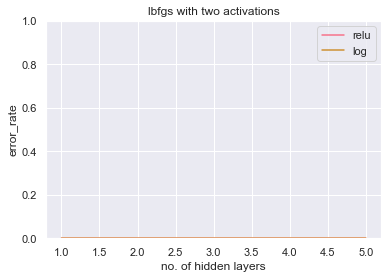

In [22]:
plt.xlabel('no. of hidden layers');
plt.ylabel('error_rate');
plt.ylim([0.0, 1]);
plt.plot(lyer_list,relu_err)
plt.plot(lyer_list,log_err)
plt.legend(('relu','log'),loc = 'upper right')
plt.title('lbfgs with two activations')

In [23]:
lyer_list = [1,2,3,4,5]
lst_err = []
for i in lyer_list:
    lst_err.append(adam_average_error(i)) 

relu_err = []
log_err = []
for i in range(len(lst_err)):
    relu_err.append(lst_err[i][0])
    log_err.append(lst_err[i][1])

Text(0.5, 1.0, 'adam with two activations')

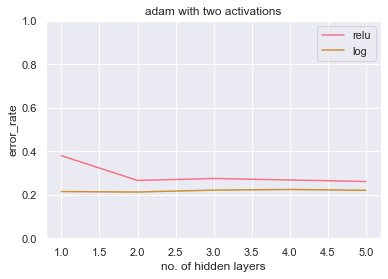

In [24]:
plt.xlabel('no. of hidden layers');
plt.ylabel('error_rate');
plt.ylim([0.0, 1]);
plt.plot(lyer_list,relu_err)
plt.plot(lyer_list,log_err)
plt.legend(('relu','log'),loc = 'upper right')
plt.title('adam with two activations')

In [27]:
# Model Evaluation using confusion matrix
mlp_lbfgs = MLPClassifier(hidden_layer_sizes=[5],solver = 'lbfgs', activation='relu',alpha=0.0001,max_iter=500, tol=1e-6)
mlp_adam_relu = MLPClassifier(hidden_layer_sizes=[5],activation='relu',alpha=0.0001,max_iter=400, tol=1e-6)
mlp_adam_log = MLPClassifier(hidden_layer_sizes=[5],activation='logistic',alpha=0.0001,max_iter=400, tol=1e-6)

mlp_lbfgs.fit(X_train, y_train)

mlp_adam_relu.fit(X_train, y_train)

mlp_adam_log = MLPClassifier(hidden_layer_sizes=[5],activation='logistic',alpha=0.0001,max_iter=400, tol=1e-6)
mlp_adam_log.fit(X_train, y_train)

y_pre_lbfgs = mlp_lbfgs.predict(X_test)
y_pre_adam_relu = mlp_adam_relu.predict(X_test)
y_pre_adam_log = mlp_adam_log.predict(X_test)

In [28]:
confusion_matrix(y_test, y_pre_lbfgs)

array([[138523,   3662],
       [  9072, 133058]])

In [29]:
confusion_matrix(y_test, y_pre_adam_relu)

array([[138429,   3756],
       [  7979, 134151]])

In [30]:
confusion_matrix(y_test, y_pre_adam_log)

array([[138336,   3849],
       [  9382, 132748]])

In [34]:
x_ori = data.iloc[:,0:30].values
y_ori = data['Class'].values
# check whether the number of rows are the same
assert x_ori.shape[0] == y_ori.shape[0]

x_scaled = preprocessing.scale(x_ori)
df_ori = pd.DataFrame(data=x_scaled)
data_ori_1 = df_ori.loc[:,[0,2,8,10,11,13,15,17,19,20,21,23,24,25,26,27,28,29]]
#data1
x_ori_1 = data_ori_1.values
# Transfer x and y to ndarray to do the resampling
x_ori_1 = x_ori_1.tolist()
x_ori_1 = np.asarray(x_ori_1).reshape(284807,18)

y_ori = data['Class'].values
y_ori = np.asarray(y_ori).reshape(284807,1)

y_lbfgs = mlp_lbfgs.predict(x_ori_1)
y_adam_relu = mlp_adam_relu.predict(x_ori_1)
y_adam_log = mlp_adam_log.predict(x_ori_1)

In [35]:
confusion_matrix(y_ori, y_lbfgs)

array([[ 54338, 229977],
       [     8,    484]])

In [36]:
confusion_matrix(y_ori, y_adam_relu)

array([[ 91261, 193054],
       [    29,    463]])

In [37]:
confusion_matrix(y_ori, y_adam_log)

array([[ 39389, 244926],
       [    27,    465]])

In [38]:
# roc
lbfgs_proba = mlp_lbfgs.predict_proba(x_ori_1)[:,1]
adam_relu_proba = mlp_adam_relu.predict_proba(x_ori_1)[:,1]
adam_log_proba = mlp_adam_log.predict_proba(x_ori_1)[:,1]

In [39]:
roc_auc_score(y_ori, lbfgs_proba)

0.904893919188739

In [40]:
roc_auc_score(y_ori, adam_relu_proba)

0.8807216932324432

In [41]:
roc_auc_score(y_ori, adam_log_proba)

0.6800978682324326

## Random Forest: without drop variables

Feature engineer

In [56]:
# Feature engineer
myDF=data.copy()
# more feature engineering
timedelta = pd.to_timedelta(myDF['Time'], unit='s')
myDF['Time_min'] = (timedelta.dt.components.minutes).astype(int)
myDF['Time_hrs'] = (timedelta.dt.components.hours).astype(int)

myDF = myDF[["Time_hrs","Time_min","V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount","Class"]]
myDF.Amount = np.log(myDF.Amount + 0.001)

In [57]:
# the function that we will use to better evaluate the model
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

In [59]:
X = myDF.drop(['Class'], axis = 1).values
y = myDF['Class'].values # transforming the data into an array

In [60]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.20)

In [61]:
# We will use Random Forest as the classifier
classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


In [62]:
# Construction of a Confusion Matrix
# In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one.

print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)

Confusion Matrix: 
[[56867    11]
 [   12    72]]

SMOTE Pipeline Score 0.9995962220427653

SMOTE + RandomForest classification
accuracy: 0.9995962220427653
precision: 0.8674698795180723
recall: 0.8571428571428571
f2: 0.8591885441527445


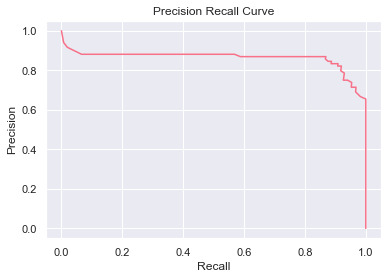

In [63]:
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [64]:
# parameters of the model
param_grid = {"max_depth": [3,5, None], "n_estimators":[3,5,10], "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )

In [65]:
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                              max_features=3, n_estimators=10,
                                              n_jobs=1, random_state=3,
                                              verbose=1),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [5, 6, 7, 8],
                         'n_estimators': [3, 5, 10]},
             scoring='recall')

In [66]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7841915085817526
{'max_depth': 5, 'max_features': 7, 'n_estimators': 5}


In [67]:
# Running the fit
rf = RandomForestClassifier(max_depth=5, max_features = 7, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=7, n_estimators=10)

In [68]:
#Testing the model 
#Predicting by X_test
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print_results("Results of RF classification", y_test, y_pred)

[[56872     6]
 [   17    67]]
Results of RF classification
accuracy: 0.9995962220427653
precision: 0.9178082191780822
recall: 0.7976190476190477
f2: 0.8190709046454768


In [69]:
roc_auc_score(y_test, smote_prediction)

0.9284747303752895

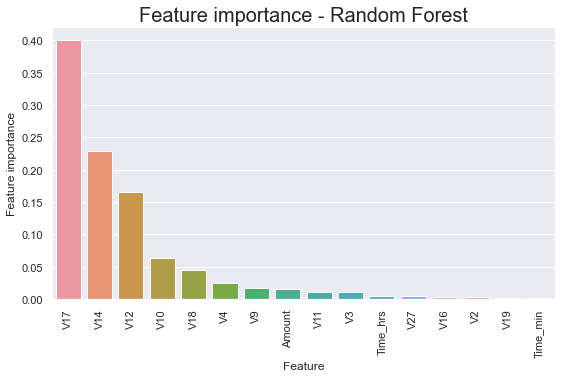

In [70]:
# Feature Importance Plot
features = ["Time_min","Time_hrs","V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount"]

plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Feature importance - Random Forest',fontsize=20)
plt.show() 

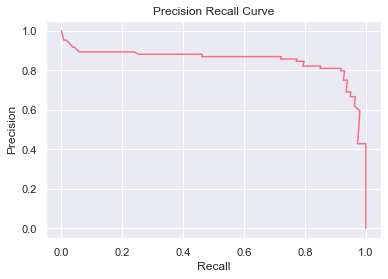

In [71]:
#Predicting proba
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [72]:
print(cross_val_score(rf, X_train, y_train, cv=10, scoring='recall'))

[0.75609756 0.70731707 0.68292683 0.68292683 0.7804878  0.75
 0.75       0.82926829 0.80487805 0.75609756]


In [73]:
print(classification_report(y_test, smote_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56878
           1       0.87      0.86      0.86        84

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [74]:
# Testing on original data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=2, test_size=0.20)
y_pred_og = rf.predict(X_test1)
print(confusion_matrix(y_test1, y_pred_og))

[[56872     6]
 [   17    67]]


## LightGBM: Scaled Amount, drop Time without resampling

In [97]:
data=credit.copy()
data['nAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
# Drop useless variables
data = data.drop(['Amount','Time'],axis=1)

In [99]:
# def X and Y
y = np.array(data.Class.tolist())
X = np.array(data.drop(['Class'],axis=1))

X2=data.drop(['Class'],axis=1)
y2=data.Class

data = data.drop('Class', 1)

Baseline Model

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 29)
(85443, 29)
(199364,)
(85443,)


In [79]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

CPU times: user 12.8 s, sys: 676 ms, total: 13.5 s
Wall time: 1.74 s


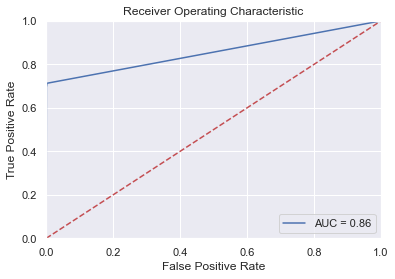

In [80]:
model_roc_auc = round(metrics.roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = metrics.roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [81]:
display(pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Predicted Negative','Predicted Positive'],index=['Actual Negative','Actual Positive']))


,Predicted Negative,Predicted Positive
Actual Negative,85246,61
Actual Positive,41,95


Random SearchCV

In [82]:
random_state=42
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test={
                 'max_depth':  [2,4,8,10,20,40,63] ,
                 'num_leaves': [7,16,256,1024,4095],
                 'feature_fraction': [0.3,0.5,0.7,0.9],
                 'subsample': [0.4,0.6,0.8,1],
                'scale_pos_weight': [1,10,100,1000,10000],#for imblanaced data:"weight of positive class in binary classification task" 
                'colsample_bytree': [0.4,0.6,0.8,1],
                'min_child_weight': [0.01,0.1,1,10,100,199] #(X_train.shape[0]/1000)
                }

#number of combinations
n_iter = 2 #(replace 2 by 200, 90 minutes)

#intialize lgbm and lunch the search
#lgb.LGBMClassifier(objective= 'binary',bagging_freq=1,learning_rate= 0.4,n_estimators=9999999,random_state=314,boosting_type='gbdt',is_unbalance=False,num_boost_round=300)
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4,is_unbalance=False)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

clf_sw = lgbm.LGBMClassifier(**lgbm_clf.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Best score reached: 0.9993178312299253 with params: {'subsample': 0.4, 'scale_pos_weight': 1, 'num_leaves': 1024, 'min_child_weight': 1, 'max_depth': 4, 'feature_fraction': 0.3, 'colsample_bytree': 0.4} 


LGBMClassifier(colsample_bytree=0.4, feature_fraction=0.3, is_unbalance=False,
               max_depth=4, metric='None', min_child_weight=1, n_jobs=4,
               num_leaves=1024, random_state=42, scale_pos_weight=1,
               subsample=0.4)

Model1

In [83]:
%%time
lgbm_clf =lgbm.LGBMClassifier(boosting_type='gbdt',colsample_bytree=0.4, feature_fraction=0.3,
               max_depth=4, metric='None', min_child_weight=1, n_jobs=4,
               num_leaves=1024, random_state=42, scale_pos_weight=2570,#2570 #
               subsample=0.4, subsample_for_bin=200000,
               subsample_freq=0,bagging_freq=1,learning_rate= 0.4,
               n_estimators=9999999,
               is_unbalance=False,num_boost_round=300)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)


CPU times: user 6.9 s, sys: 110 ms, total: 7.01 s
Wall time: 1.89 s


LGBMClassifier(bagging_freq=1, colsample_bytree=0.4, feature_fraction=0.3,
               is_unbalance=False, learning_rate=0.4, max_depth=4,
               metric='None', min_child_weight=1, n_estimators=9999999,
               n_jobs=4, num_boost_round=300, num_leaves=1024, random_state=42,
               scale_pos_weight=2570, subsample=0.4)

In [84]:
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

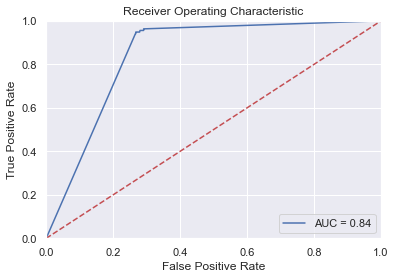

In [85]:
model_roc_auc = round(metrics.roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = metrics.roc_curve(y_test, y_score)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [86]:
display(pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Predicted Negative','Predicted Positive'],index=['Actual Negative','Actual Positive']))

,Predicted Negative,Predicted Positive
Actual Negative,62496,22811
Actual Positive,8,128


Model2

In [87]:
%%time
lgbm_clf2 =lgbm.LGBMClassifier(boosting_type='gbdt',colsample_bytree=0.4, feature_fraction=0.3,
               max_depth=4, metric='None', min_child_weight=1, n_jobs=4,
               num_leaves=1024, random_state=42, scale_pos_weight=900,
               subsample=0.4, subsample_for_bin=200000,
               subsample_freq=0,bagging_freq=1,learning_rate= 0.4,
               n_estimators=9999999,
               is_unbalance=False,num_boost_round=300)

lgbm_clf2.fit(X_train, y_train)
lgbm_clf2.fit(X_train, y_train)

CPU times: user 7.12 s, sys: 109 ms, total: 7.23 s
Wall time: 1.93 s


LGBMClassifier(bagging_freq=1, colsample_bytree=0.4, feature_fraction=0.3,
               is_unbalance=False, learning_rate=0.4, max_depth=4,
               metric='None', min_child_weight=1, n_estimators=9999999,
               n_jobs=4, num_boost_round=300, num_leaves=1024, random_state=42,
               scale_pos_weight=900, subsample=0.4)

In [88]:
y_pred = lgbm_clf2.predict(X_test)
y_score = lgbm_clf2.predict_proba(X_test)[:,1]

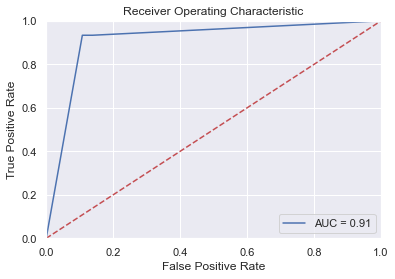

In [89]:
model_roc_auc = round(metrics.roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = metrics.roc_curve(y_test, y_score)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [90]:
display(pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Predicted Negative','Predicted Positive'],index=['Actual Negative','Actual Positive']))


,Predicted Negative,Predicted Positive
Actual Negative,76005,9302
Actual Positive,9,127


Feature Importance

In [91]:
def feature_importance(X,y):
    lgbm_clf.fit(X,y)
    lgbm_clf.booster_.feature_importance()
    
    # importance of each attribute
    fea_imp_ = pd.DataFrame({'cols':X.columns, 'fea_imp':lgbm_clf.feature_importances_})
    print(fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False))
    important_features = list(fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False).head(100)['cols'])
    return important_features


In [93]:
best_params={'subsample': 0.4, 'scale_pos_weight': 2570, 'num_leaves': 1024,
             'min_child_weight': 1, 'max_depth': 4, 'feature_fraction': 0.3, 
             'colsample_bytree': 0.4,'subsample_freq':0,'bagging_freq':1} 

Plot feature importances…


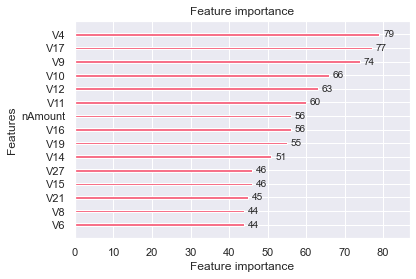

In [102]:
d_train = lgb.Dataset(X2, label=y2)
model = lgb.train(params=best_params,train_set=d_train)
print('Plot feature importances…')
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()
#imf=feature_importance(X_df,Y_df)